In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
import argparse
import time
import os
from model import LSTMModel, CNN_LSTM

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# parser = argparse.ArgumentParser(description='Add these argument for training')
# parser.add_argument('--dir', default='results', help='directory for saving trianed mode')
# parser.add_argument('--feature', required= True)

# parser.add_argument('--lr', default=0.005, help='learning rate')
# parser.add_argument('--epochs', default=10, help='epoch number')
# parser.add_argument('--batch_size', default=32)
# args = parser.parse_args()

# ## Set parameter for the model
# directory = args.dir                # directory for saving model
# batch_size = int(args.batch_size)   # batch size
# learning_rate = float(args.lr)
# num_epochs = int(args.epochs)

### **Data Processing**

In [4]:
data = pd.read_csv('data/solar_wind_parameters_data_1_hourly_all.csv')
print(data.shape)
# data = data.drop(columns=['Unnamed: 0','Timestamp'])

data.head()

(212088, 15)


,Unnamed: 0,Timestamp,YEAR,DOY,HR,Scalar_B,BX_GSE_GSM,BY_GSE,BZ_GSE,BY_GSM,BZ_GSM,Proton_Density,SW_Plasma_Temperature,SW_Plasma_Speed,Dst-index
0,0,1999-1-0,1999,1,0,6.792,-1.686,2.710,5.118,1.284,5.650,6.070,81042.0,415.28,-7.0
1,1,1999-1-1,1999,1,1,6.884,-4.513,0.390,3.240,-0.361,3.255,7.027,90525.0,400.50,-4.0
2,2,1999-1-2,1999,1,2,7.073,-3.813,-0.826,4.949,-1.808,4.681,6.793,88927.0,405.24,-4.0
3,3,1999-1-3,1999,1,3,6.644,-3.535,1.860,0.244,1.753,0.515,7.129,104190.0,413.07,-8.0
4,4,1999-1-4,1999,1,4,6.645,-3.082,1.953,2.664,1.730,2.866,6.963,101510.0,415.57,-8.0


In [5]:
features = ['Scalar_B', 'BX_GSE_GSM', 'BY_GSE', 'BZ_GSE', 'BY_GSM', 'BZ_GSM', 'Proton_Density', 'SW_Plasma_Temperature', 'SW_Plasma_Speed']
target = ['Dst-index']

# Select the features and target
data = data[features + target]
# data.head()
X = data[features].values
y = data[target].values

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, shuffle=False)

# Scale X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale y (if regression)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# merge X and y
train_data = np.concatenate((X_train_scaled, y_train_scaled), axis=1)
test_data = np.concatenate((X_test_scaled, y_test_scaled), axis=1)

# Split the data into sequences
def sequence(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1]) # all columns except the last
        y.append(data[i+seq_length, -1])  # target is the last column
        # print(f'X:{np.array(X)}, Y:{np.array(y)}')
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
X_train, y_train = sequence(train_data, SEQ_LENGTH)
X_test, y_test = sequence(test_data, SEQ_LENGTH)

X shape: (212088, 9)
y shape: (212088, 1)


In [6]:
test_df = pd.DataFrame(test_data, columns=features + target)
test_df.head()

,Scalar_B,BX_GSE_GSM,BY_GSE,BZ_GSE,BY_GSM,BZ_GSM,Proton_Density,SW_Plasma_Temperature,SW_Plasma_Speed,Dst-index
0,0.046762,0.561862,0.424509,0.606628,0.511506,0.566617,0.015191,0.062440,0.339137,0.392045
1,0.048212,0.542359,0.434032,0.597517,0.523866,0.559256,0.015191,0.072289,0.333805,0.409091
2,0.047306,0.584430,0.427474,0.617164,0.513498,0.575187,0.015191,0.085370,0.323059,0.397727
3,0.050164,0.591473,0.429150,0.619695,0.514943,0.577123,0.015191,0.080785,0.317540,0.392045
4,0.046915,0.583005,0.437697,0.614726,0.525425,0.574393,0.015191,0.066392,0.313719,0.386364


In [7]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_test_tensor shape: {X_test_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')

# Create a DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

X_train_tensor shape: torch.Size([169646, 24, 9])
y_train_tensor shape: torch.Size([169646])
X_test_tensor shape: torch.Size([42394, 24, 9])
y_test_tensor shape: torch.Size([42394])


### **Model**

In [8]:

learning_rate = 0.005
directory = 'results/run4'

input_size = len(features)
hidden_layer_size = 48
output_size = 1
model = LSTMModel(input_size, hidden_layer_size, output_size).to(device)
# print(f'Model: {model} input_size: {input_size}, hidden_layer_size: {hidden_layer_size}, output_size: {output_size}')
print(summary(model, input_size=(batch_size, SEQ_LENGTH, input_size)))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 1]                   --
├─LSTM: 1-1                              [32, 24, 48]              11,328
├─Linear: 1-2                            [32, 1]                   49
Total params: 11,377
Trainable params: 11,377
Non-trainable params: 0
Total mult-adds (M): 8.70
Input size (MB): 0.03
Forward/backward pass size (MB): 0.30
Params size (MB): 0.05
Estimated Total Size (MB): 0.37


### **Training Loop**

In [9]:

num_epochs = 10

# Training Loop
train_loss = 0.0
best_loss = 1e10
best_epoch = 0
rec = []
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    for i, data in enumerate(train_loader):
        X_train, y_train = data
        optimizer.zero_grad()
        y_pred = model(X_train)

        # Reshape y_pred to match the size of y_train
        y_pred = y_pred.view(-1)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    end = time.time()
        
    train_loss = train_loss / len(train_loader)

    # Test the model
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X_test, y_test = data
            y_pred = model(X_test)

            # Reshape y_pred to match the size of y_test
            y_pred = y_pred.view(-1)

            loss = criterion(y_pred, y_test)
            test_loss += loss.item()
    test_loss = test_loss / len(test_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Time: {end-start:.2f} sec")

    if test_loss < best_loss:
        print(f"Model improved from {best_loss:.4f} to {test_loss:.4f} Saving model...")
        best_loss = test_loss
        best_epoch = epoch + 1

        # Save checkpoint
        checkpoint = {
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            'input_size': model.input_size,
            'hidden_size': model.hidden_size,
            'num_layers': model.num_layers,
        }
        torch.save(checkpoint, f'./{directory}/model{round(best_loss*10000)}.pth')
        torch.save(checkpoint, f'./{directory}/best_model.pth')

    # Record results
    rec.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'test_loss': test_loss,
    })

# Write results to csv
df = pd.DataFrame(rec)
df.to_csv(f'{directory}/results.csv', index=False)

print(f"Finihsed training after {num_epochs} epochs. Best loss: {best_loss:.4f} at epoch {best_epoch}")

Epoch [1/10], Train Loss: 0.0087, Test Loss: 0.0043, Time: 3.45 sec
Model improved from 10000000000.0000 to 0.0043 Saving model...
Epoch [2/10], Train Loss: 0.0076, Test Loss: 0.0041, Time: 3.40 sec
Model improved from 0.0043 to 0.0041 Saving model...
Epoch [3/10], Train Loss: 0.0071, Test Loss: 0.0038, Time: 3.40 sec
Model improved from 0.0041 to 0.0038 Saving model...
Epoch [4/10], Train Loss: 0.0063, Test Loss: 0.0038, Time: 3.48 sec
Model improved from 0.0038 to 0.0038 Saving model...
Epoch [5/10], Train Loss: 0.0057, Test Loss: 0.0037, Time: 3.44 sec
Model improved from 0.0038 to 0.0037 Saving model...
Epoch [6/10], Train Loss: 0.0054, Test Loss: 0.0036, Time: 3.41 sec
Model improved from 0.0037 to 0.0036 Saving model...
Epoch [7/10], Train Loss: 0.0051, Test Loss: 0.0035, Time: 3.45 sec
Model improved from 0.0036 to 0.0035 Saving model...
Epoch [8/10], Train Loss: 0.0047, Test Loss: 0.0034, Time: 3.39 sec
Model improved from 0.0035 to 0.0034 Saving model...
Epoch [9/10], Train Lo

### **Test the Result**

Load Checkpoint (Optional)

In [10]:
# Load the trained model
# path = 'results/run4/best_model.pth'
# checkpoint = torch.load(f'{path}', map_location=device)
# print(checkpoint.keys())

# # Recreate the model
# model = LSTMModel(checkpoint['input_size'], checkpoint['hidden_size'], output_size=1).to(device)

# Load the model weights
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()  # Set to evaluation mode

# print("Model loaded successfully!")

In [ ]:

# Predict
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # print(f'y_pred:{y_pred.shape} {y_pred}')

# Convert true values to NumPy
y_test = y_test_tensor.cpu().numpy()

# Fix the shape by flattening y_pred
y_pred = y_pred.cpu().numpy().flatten()
# print(f'y_pred:{y_pred.shape} {y_pred}')

# Inverse transform the scaled values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f'y_pred_original:{y_pred_original.shape} {y_pred_original}')

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'MSE: {mse:.2f}')


y_pred_original:(42394,) [-24.22175  -24.346869 -24.233473 ... -10.638731 -10.499261 -10.332201]


### Plot

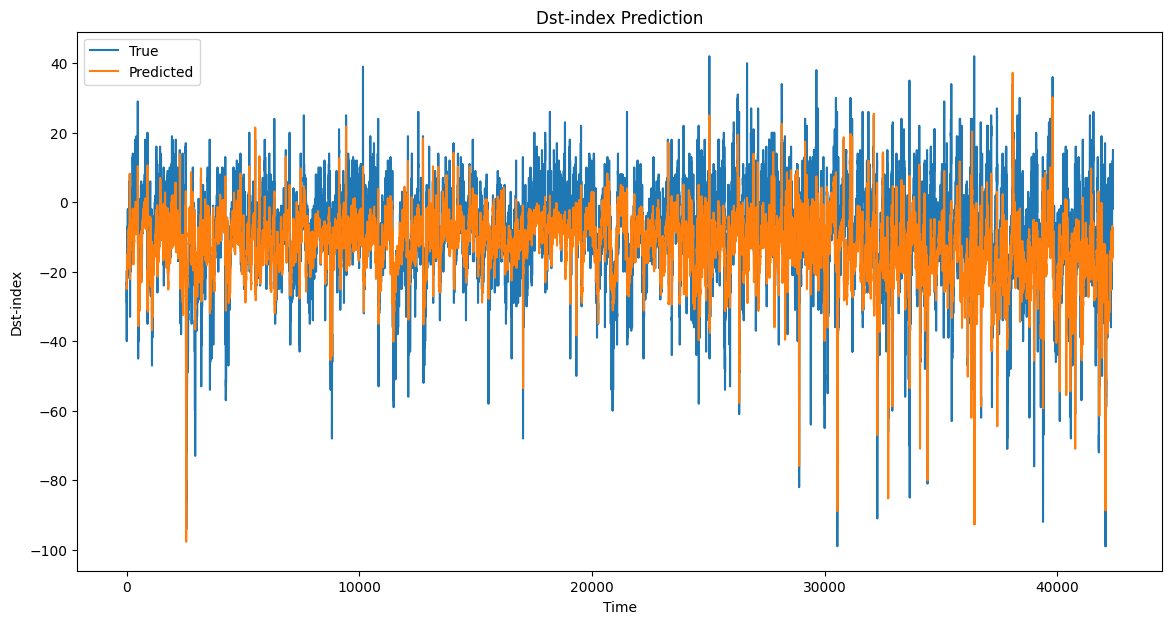

In [12]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='True')
plt.plot(y_pred_original, label='Predicted')
plt.title('Dst-index Prediction')
plt.xlabel('Time')
plt.ylabel('Dst-index')
plt.legend()
plt.show()